### Step 1: Import required libraries

In [7]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
import optuna
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from matplotlib import pyplot as plt


### Step 2: Define the Environment

In [8]:
class IbuprofenEnv(gym.Env):
    def __init__(self):
        super(IbuprofenEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)

        # Pharmacokinetics parameters
        self.therapeutic_range = (10, 50)  # Therapeutic range for the drug (mg/L)
        self.half_life = 2.0  # Plasma half-life in hours
        self.clearance_rate = 0.693 / self.half_life  # First-order decay constant
        self.time_step_hours = 6  # Each time step represents 6 hours

        self.max_steps = 24  # 24 time steps = 6-hour intervals over 6 days
        self.current_step = 0
        self.plasma_concentration = 0.0
        self.np_random = None  # RNG for seeding

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.current_step = 0
        self.plasma_concentration = 0.0
        return np.array([self.plasma_concentration], dtype=np.float32), {}  # Return obs and info

    def step(self, action):
        """
        Take an action (dose) and return the new state, reward, terminated, truncated, and info.
        """
        dose_mg = action * 200  # Map action index to dose in mg
        absorbed = dose_mg / 10  # Simplified absorption model
        self.plasma_concentration += absorbed
        self.plasma_concentration *= np.exp(-self.clearance_rate * self.time_step_hours)

        # Calculate the reward
        if self.therapeutic_range[0] <= self.plasma_concentration <= self.therapeutic_range[1]:
            reward = 10
        elif self.plasma_concentration > 100:
            reward = -20
        elif self.plasma_concentration < self.therapeutic_range[0]:
            reward = -5
        else:
            reward = -10

        self.current_step += 1
        terminated = self.current_step >= self.max_steps  # End the episode when max_steps are reached
        truncated = False  # No custom truncation logic
        info = {}  # Additional information, if any

        return (
            np.array([self.plasma_concentration], dtype=np.float32),
            reward,
            terminated,
            truncated,
            info,
        )

### Step 3: Define Custom Callback
This is to track and log the rewards earned in each episode

In [9]:
class RewardLoggingCallback(BaseCallback):
    def __init__(self):
        super(RewardLoggingCallback, self).__init__()
        self.episode_rewards = []
        self.current_rewards = []

    def _on_step(self) -> bool:
        reward = self.locals["rewards"]
        done = self.locals["dones"]
        self.current_rewards.append(reward)

        if done:
            self.episode_rewards.append(sum(self.current_rewards))
            self.current_rewards = []
        return True


### Step 4: Wrap the Environment
To ensure that it is compatible with stable_baselines3

In [10]:
env = DummyVecEnv([lambda: IbuprofenEnv()])

### Step 5: Define Optuna Optimization Function

In [11]:
def optimize_ppo(trial):
    # Provide some hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    n_epochs = trial.suggest_int('n_epochs', 3, 10)
    gamma = trial.suggest_float('gamma', 0.9, 0.999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.4)
    ent_coef = trial.suggest_float('ent_coef', 1e-4, 0.01, log=True)

    # Create PPO agent with suggested hyperparameters
    agent = PPO(
        "MlpPolicy",
        env,
        verbose=0,
        learning_rate=learning_rate,
        batch_size=batch_size,
        n_epochs=n_epochs,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
    )

    # Train the agent for a fixed number of timesteps
    agent.learn(total_timesteps=5000)

    # Evaluate the agent over multiple episodes
    total_rewards = []
    for _ in range(10):  # Evaluate over 10 episodes
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = agent.predict(state, deterministic=True)
            state, reward, done, info = env.step(action)  # Expect 4 values from DummyVecEnv
            total_reward += reward
        total_rewards.append(total_reward)

    return np.mean(total_rewards)


### Step 6: Run Optuna

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=20)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-11-26 21:12:42,900] A new study created in memory with name: no-name-41ff4f8b-1cd8-467a-831e-24e6ac3d5550
[I 2024-11-26 21:12:46,465] Trial 0 finished with value: 240.0 and parameters: {'learning_rate': 0.00022168350100334772, 'batch_size': 128, 'n_epochs': 7, 'gamma': 0.9669231367103773, 'gae_lambda': 0.8204677988400829, 'clip_range': 0.10896311553519585, 'ent_coef': 0.0030140675445420313}. Best is trial 0 with value: 240.0.
[I 2024-11-26 21:12:48,562] Trial 1 finished with value: 240.0 and parameters: {'learning_rate': 0.00020572964235738553, 'batch_size': 256, 'n_epochs': 8, 'gamma': 0.9084202244255419, 'gae_lambda': 0.9593166878065015, 'clip_range': 0.22950132477018004, 'ent_coef': 0.0022207761205018358}. Best is trial 0 with value: 240.0.
[I 2024-11-26 21:12:50,606] Trial 2 finished with value: 240.0 and parameters: {'learning_rate': 3.4727461461305204e-05, 'batch_size': 256, 'n_epochs': 6, 'gamma': 0.980525739971674, 'gae_lambda': 0.9844960717446231, 'clip_range': 0.23687

Best hyperparameters: {'learning_rate': 0.00022168350100334772, 'batch_size': 128, 'n_epochs': 7, 'gamma': 0.9669231367103773, 'gae_lambda': 0.8204677988400829, 'clip_range': 0.10896311553519585, 'ent_coef': 0.0030140675445420313}


### Step 7: Train optimized model

In [13]:
best_params = study.best_params
callback = RewardLoggingCallback()
final_agent = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    n_epochs=best_params['n_epochs'],
    gamma=best_params['gamma'],
    gae_lambda=best_params['gae_lambda'],
    clip_range=best_params['clip_range'],
    ent_coef=best_params['ent_coef'],
)

final_agent.learn(total_timesteps=100000, callback=callback)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3896 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3328        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015581134 |
|    clip_fraction        | 0.394       |
|    clip_range           | 0.109       |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.000742    |
|    learning_rate        | 0.000222    |
|    loss                 | 52.4        |
|    n_updates            | 7           |
|    policy_gradient_loss | -0.0387     |
|    value_loss           | 131         |
-----------------------------------------
-----------------

### Step 8: Plot Learning Curve

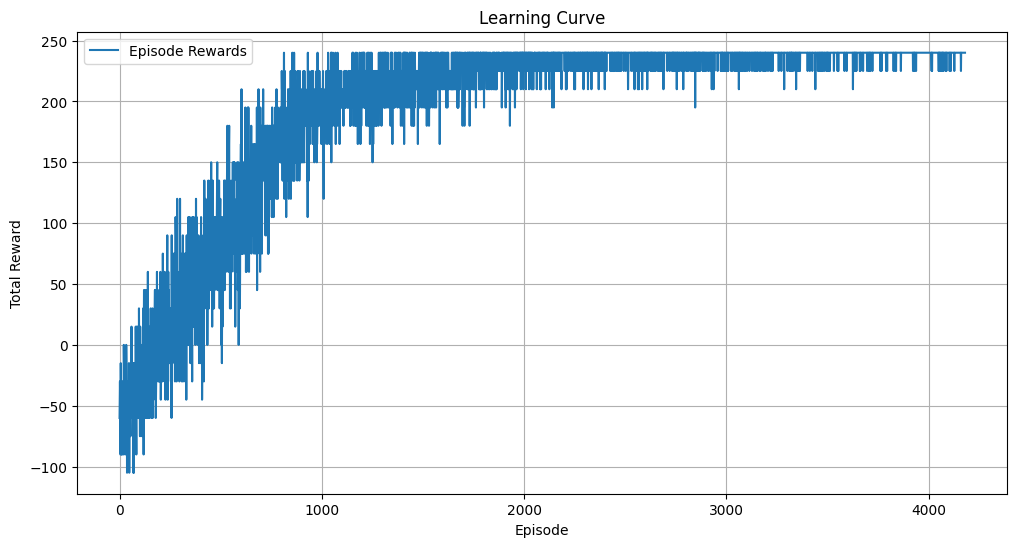

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(callback.episode_rewards)), callback.episode_rewards, label="Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()


### Step 9: Evaluate final agent

In [15]:
state_trajectory = []
state = env.reset()  # No need to unpack info, as DummyVecEnv returns only observations
done = False

while not done:
    state_trajectory.append(state[0])  # Record plasma concentration
    action, _ = final_agent.predict(state, deterministic=True)
    state, reward, done, info = env.step(action)  # Correct unpacking for DummyVecEnv


### Step 10: Plot plasma concentration over time

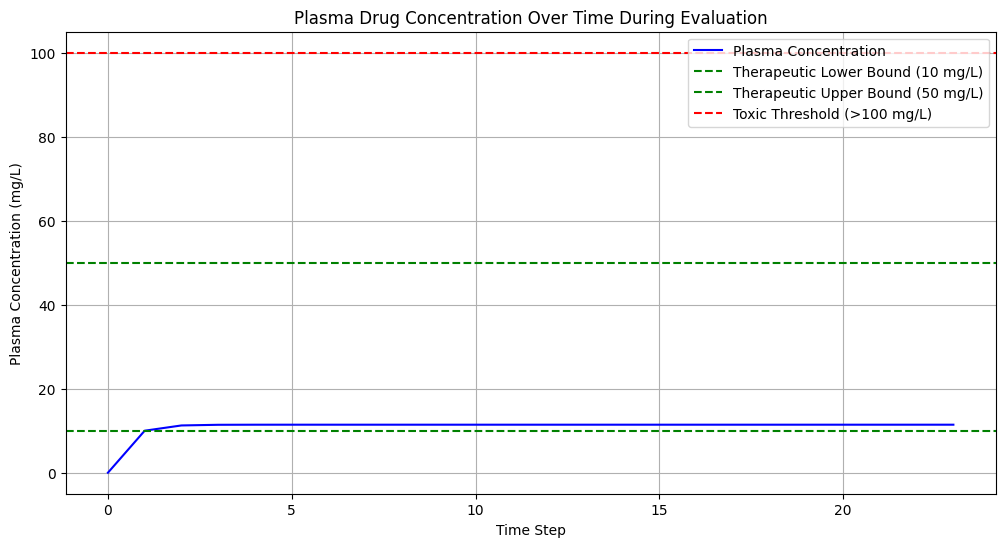

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(state_trajectory)), state_trajectory, label='Plasma Concentration', color='b')
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')
plt.xlabel('Time Step')
plt.ylabel('Plasma Concentration (mg/L)')
plt.title('Plasma Drug Concentration Over Time During Evaluation')
plt.legend()
plt.grid()
plt.show()
